# 花粉飛散量予測

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from optuna.integration import lightgbm as lgb

from matplotlib import pyplot as plt
import seaborn as sns

### データの読み込み

In [2]:
train = pd.read_csv("data/train_v2.csv", dtype = {"datetime": str}, na_values = ["欠測"])
test = pd.read_csv("data/test_v2.csv", dtype = {"datetime": str}, na_values = ["欠測"])
sample_submission = pd.read_csv("data/sample_submission.csv", dtype = {"datetime": str})

In [3]:
# 日時を文字列型からdatetime型へ変換する。
to_datetime = lambda datetime: (
    pd.to_datetime(
        pd.DataFrame({
            "year": datetime.str[0:4],
            "month": datetime.str[4:6],
            "day": datetime.str[6:8],
            "hour": datetime.str[8:10],
        })
    )
)
train["datetime"] = to_datetime(train["datetime"])
test["datetime"] = to_datetime(test["datetime"])

---

## 前処理

### 整形

In [4]:
# 拠点で横持ちになっているデータを縦持ちに変換する。
def unpivot(data):
    return pd.concat([
        (
            data
            .loc[:, lambda df: df.columns.isin(["datetime"]) | df.columns.str.endswith("_utsunomiya")]
            .rename(columns = lambda x: x.replace("_utsunomiya", ""))
            .assign(area = "utsunomiya")
        ),
        (
            data
            .loc[:, lambda df: df.columns.isin(["datetime"]) | df.columns.str.endswith("_chiba")]
            .rename(columns = lambda x: x.replace("_chiba", ""))
            .assign(area = "chiba")
        ),
        (
            data
            .loc[:, lambda df: df.columns.isin(["datetime"]) | df.columns.str.endswith("_tokyo")]
            .rename(columns = lambda x: x.replace("_tokyo", ""))
            .assign(area = "tokyo")
        ),
    ], ignore_index = True)

In [5]:
train = unpivot(train)
test = unpivot(test)

### 変換

In [6]:
# 整形済みデータから特徴量を抽出する。
def transform(data):
    data = data.copy()

    # 日時
    data["year"] = data["datetime"].dt.year
    data["month"] = data["datetime"].dt.month
    data["hour"] = data["datetime"].dt.hour

    # 風向と風速
    data["wind_x"] = (np.cos(data["winddirection"] / 16 * 2 * np.pi) * data["windspeed"]).mask(data["winddirection"] == 0, 0)
    data["wind_y"] = (np.sin(data["winddirection"] / 16 * 2 * np.pi) * data["windspeed"]).mask(data["winddirection"] == 0, 0)
    data = data.drop(columns = ["winddirection", "windspeed"])

    # 降水量・気温・風速の移動平均
    ewm = lambda df, columns, halflife: (
        df
        .sort_values(["area", "year", "datetime"])
        .set_index("datetime")
        .groupby(["area", "year"])[columns].ewm(halflife = halflife).mean()
    )
    columns = ["wind_x", "wind_y", "temperature", "precipitation"]
    data = data.merge(ewm(data, columns, 1), how = "left", on = ["area", "year", "datetime"], suffixes = ("", "_ewm1h"))
    data = data.merge(ewm(data, columns, 24 * 1), how = "left", on = ["area", "year", "datetime"], suffixes = ("", "_ewm1d"))
    data = data.merge(ewm(data, columns, 24 * 7 * 1), how = "left", on = ["area", "year", "datetime"], suffixes = ("", "_ewm1w"))

    # 2週間前の花粉飛散量の移動平均
    data = data.merge(
        right = (
            data
            .sort_values(["area", "year", "datetime"])
            .assign(pollen_prev2w = lambda df: df.groupby(["area", "year"])["pollen"].shift(24 * 14))
            .set_index("datetime")
            .groupby(["area", "year"])["pollen_prev2w"].ewm(halflife = 24 * 7).mean()
            .rename("pollen_prev2w_ewm1w")
        ),
        how = "right",
        on = ["area", "year", "datetime"]
    )

    # 拠点
    data["area"] = data["area"].astype("category")

    return data

In [7]:
# 花粉飛散量が欠損している場合、0とみなす。
train.loc[lambda df: df["pollen"] < 0, "pollen"] = 0

# 整形済みデータから特徴量を抽出する。
# 過去を参照する計算 (移動平均など) が含まれるため、抽出前に学習データとテストデータを結合しておく。
traintest = pd.concat([train, test], ignore_index = True)
traintest = transform(traintest)
train = traintest.loc[lambda df: df["datetime"] < "2020-04-01 01:00:00", :].reset_index(drop = True)
test = traintest.loc[lambda df: df["datetime"] >= "2020-04-01 01:00:00", :].reset_index(drop = True)

# クロスバリデーションに用いるグループを作成する。
# グループを作成するのは、学習データに近い時点の予測が当たりやすい問題を緩和するため。
# 学習データを2週間ずつ (テストデータの期間と同じ長さ) のグループに分割する。
train["group"] = train["datetime"].dt.year * 100 + train["datetime"].dt.day_of_year // 14
train = train.sort_values("group")
train_group = train["group"].value_counts().sort_index()

---

## 学習

### ハイパーパラメーターの調整

In [8]:
# # OptunaでLightGBMのハイパーパラメーターを調整する。
# cv = lgb.LightGBMTunerCV(
#     params = {
#         "objective": "regression",
#         "metric": "rmse",
#         "deterministic": True,
#         "force_row_wise": True,
#         "verbosity": -1,
#     },
#     train_set = lgb.Dataset(
#         data = train.drop(columns = ["datetime", "group", "pollen"]),
#         label = np.log1p(train["pollen"]),
#         group = train_group
#     ),
#     num_boost_round = 100,
#     folds = GroupShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0),
#     seed = 0,
#     optuna_seed = 0,
#     verbose_eval = None
# )
# cv.run()
# best_params = cv.best_params

best_params = {
    "objective": "regression",
    "metric": "rmse",
    "lambda_l1": 9.324492323446151,
    "lambda_l2": 2.6569488622699346e-08,
    "num_leaves": 99,
    "feature_fraction": 0.652,
    "bagging_fraction": 0.8750350228503905,
    "bagging_freq": 4,
    "min_child_samples": 50,
    "verbosity": -1,
}

### 学習

In [9]:
cv = lgb.cv(
    params = best_params,
    train_set = lgb.Dataset(
        data = train.drop(columns = ["datetime", "group", "pollen"]),
        label = np.log1p(train["pollen"]),
        group = train_group
    ),
    num_boost_round = 100,
    # ランダムにデータを変えて予測器を100個作る。
    folds = GroupShuffleSplit(n_splits = 100, test_size = 0.2, random_state = 0),
    seed = 0,
    return_cvbooster = True
)
model = cv["cvbooster"]

In [10]:
print(cv["rmse-mean"][-1])

1.1811165199861484


### 特徴量重要度

In [11]:
importance = []
for booster in model.boosters:
    importance.append(pd.DataFrame({
        "column": booster.feature_name(),
        "importance": booster.feature_importance(importance_type = "gain")
    }))
importance = pd.concat(importance, ignore_index = True)
importance = importance.groupby("column", as_index = False)["importance"].agg(["mean", "std"])
importance.sort_values("mean", ascending = False).style.bar(subset = ["mean", "std"])

---

## 予測

### 予測

In [12]:
test_pred_all = pd.DataFrame(np.expm1(np.array(model.predict(test.drop(columns = ["datetime", "pollen"])))))

### 予測値の分布 (千葉)

In [13]:
def show_pollen_pred_dist(test, test_pred_all, area):
    test_pred_all_melt = (
        test[["area", "datetime"]]
        .reset_index()
        .merge(
            right = (
                test_pred_all
                .stack()
                .rename("pollen_pred")
                .rename_axis(["k", "index"])
                .reset_index()
            ),
            how = "left",
            on = "index"
        )
    )

    plt.figure(figsize = (8, 64))
    sns.boxplot(
        data = test_pred_all_melt.loc[lambda df:  df["area"] == area, :],
        y = "datetime",
        x = "pollen_pred",
    )
    plt.xlim(-25, 100)
    plt.grid(axis = "x")
    plt.show()

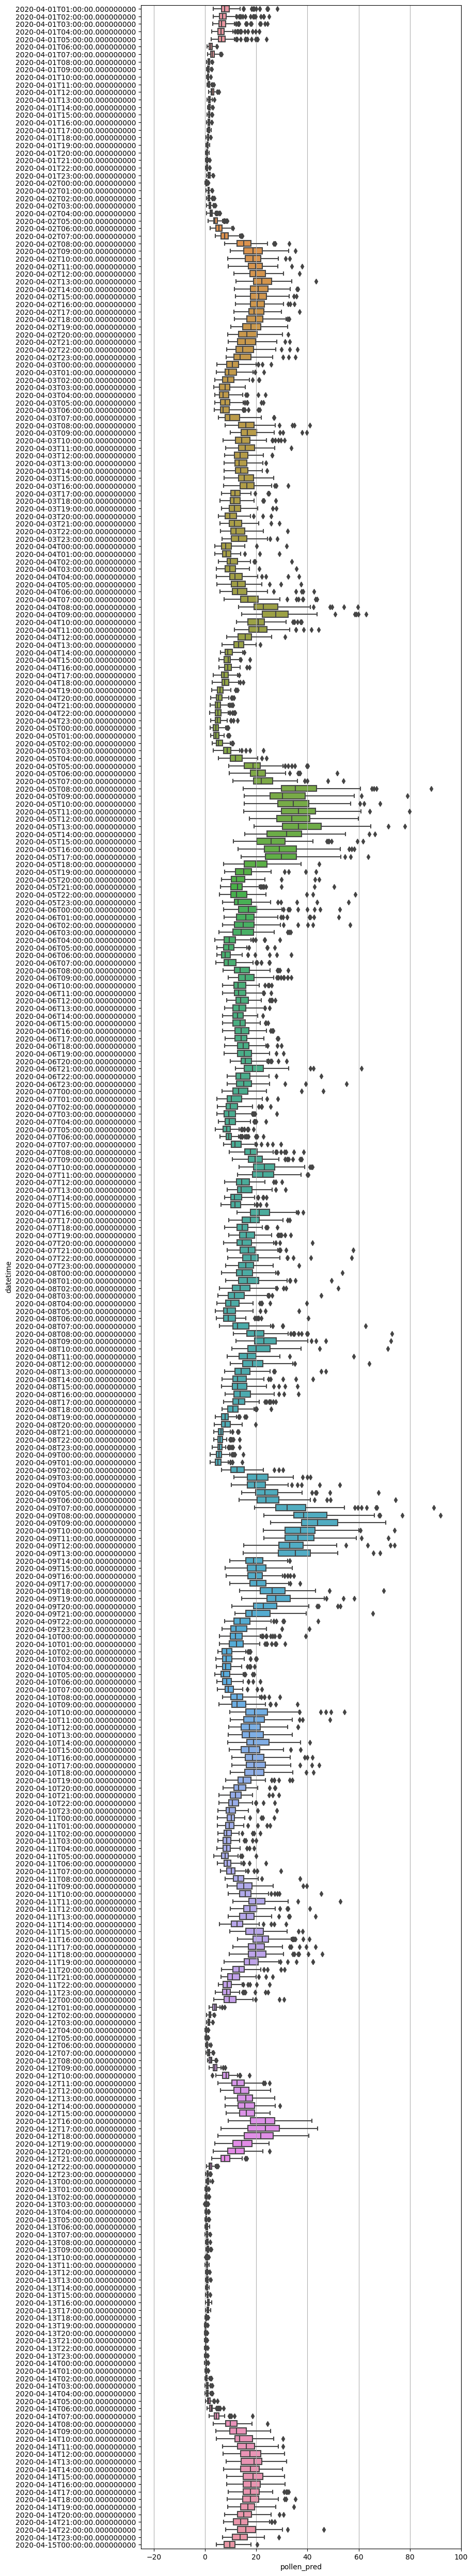

In [14]:
show_pollen_pred_dist(test, test_pred_all, "chiba")

### 予測値の分布 (府中)

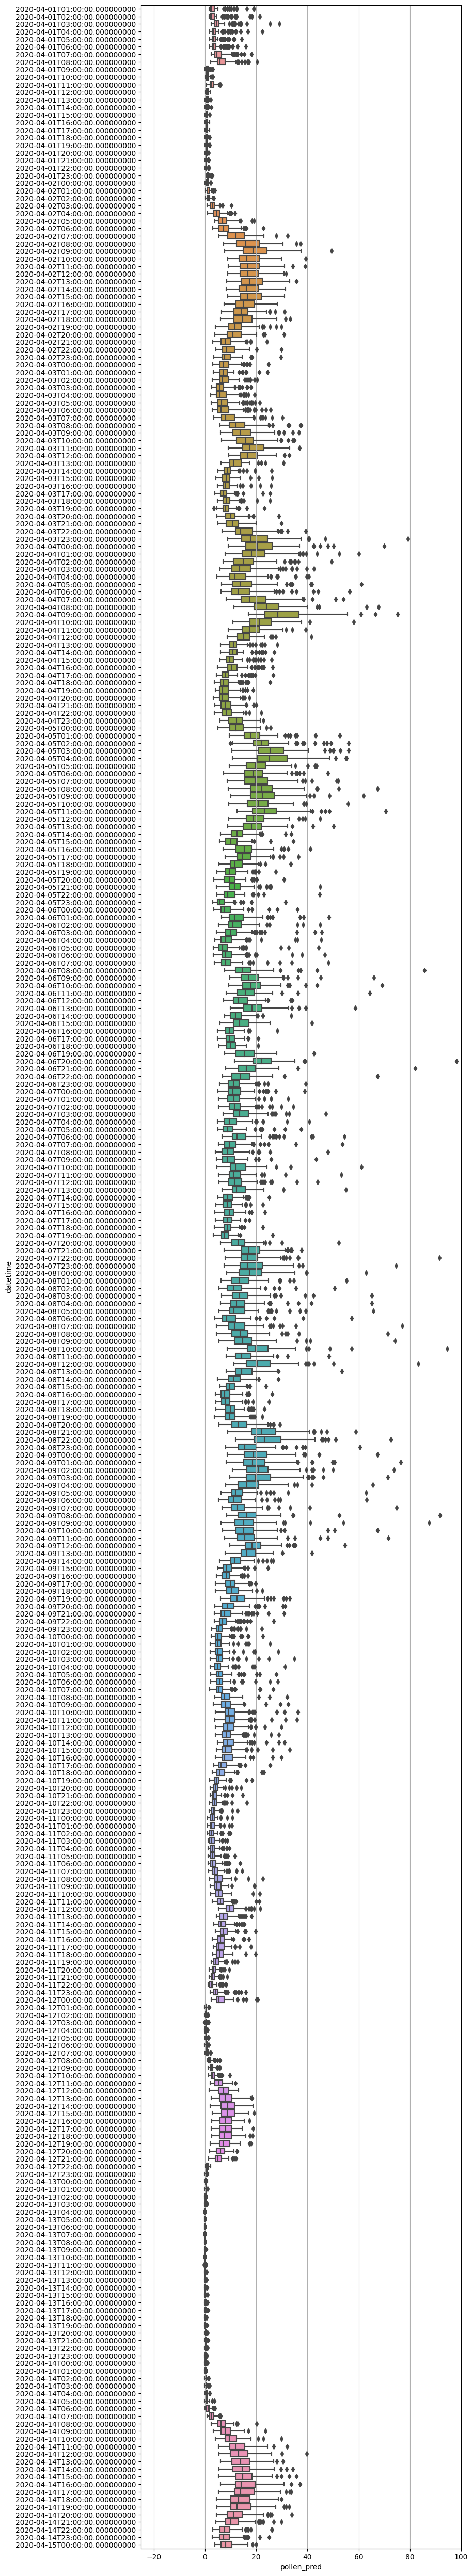

In [15]:
show_pollen_pred_dist(test, test_pred_all, "tokyo")

### 予測値の分布 (宇都宮)

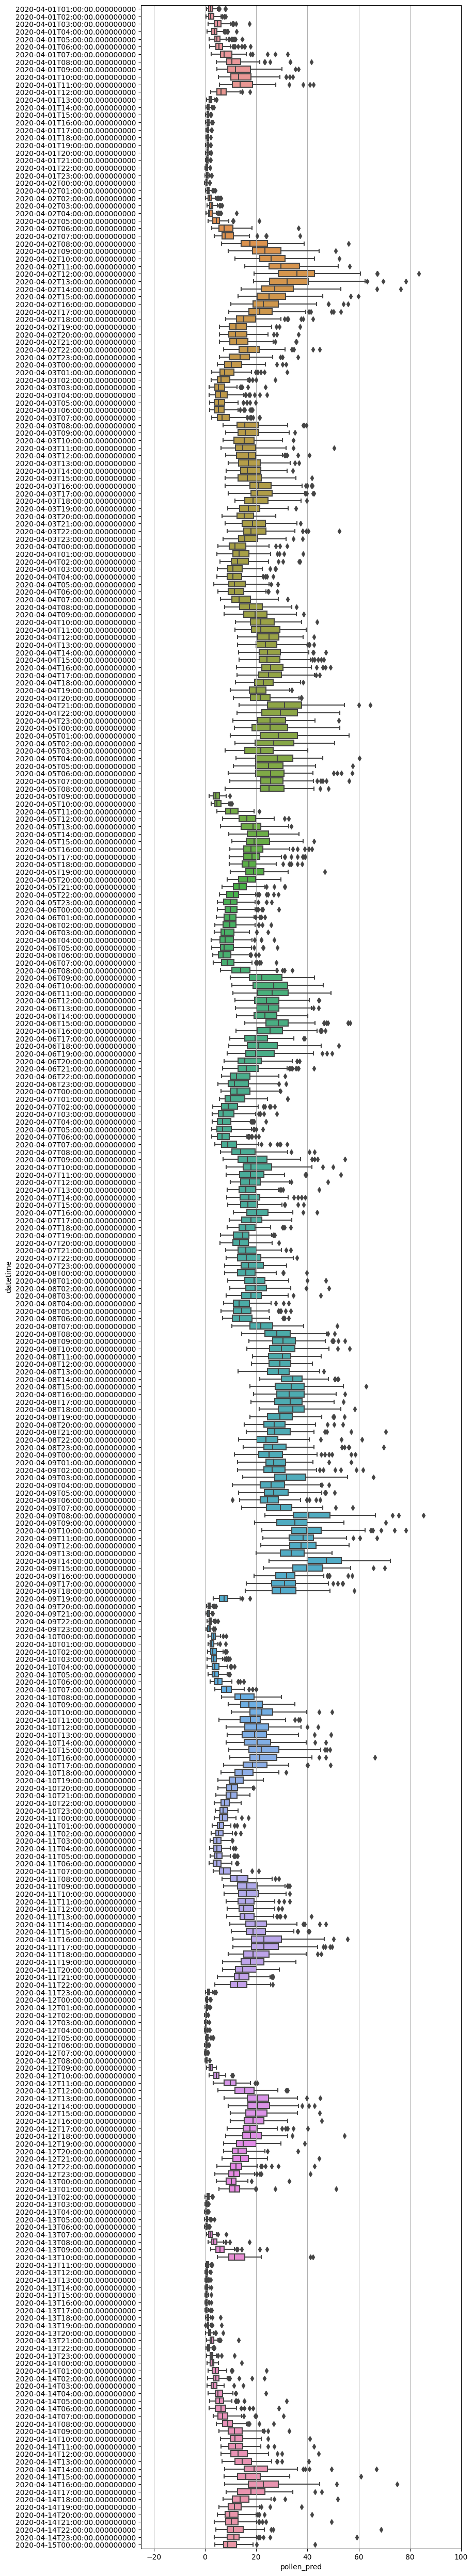

In [16]:
show_pollen_pred_dist(test, test_pred_all, "utsunomiya")

### 予測値の補正

In [17]:
test["pollen_pred_q05"] = test_pred_all.quantile(q = 0.05).to_numpy()
test["pollen_pred_max"] = test_pred_all.max().to_numpy()
pollen_chiba_highest = (
    train
    .loc[lambda df: (
        (df["area"] == "chiba")
        & (df["datetime"].dt.month == 4)
        & (df["datetime"].dt.day.between(1, 14))
    ), "pollen"]
    .quantile(q = 0.99)
)

# 予測値の上振れ対策として、5パーセンタイルを最終的な予測値として用いる。
test["pollen_pred"] = test["pollen_pred_q05"]
# 花粉飛散量がバーストしていると思われる時刻の予測値を上方修正する。
test["pollen_pred"] = test["pollen_pred"].mask((test["area"] == "chiba") & (test["pollen_pred_q05"] > 20), test["pollen_pred_max"])
test["pollen_pred"] = test["pollen_pred"].mask((test["area"] == "chiba") & (test["pollen_pred_q05"] > 27), pollen_chiba_highest)

# 花粉飛散量は大半が4の倍数になっているため、予測値も4の倍数に丸める。
test["pollen_pred"] = test["pollen_pred"] // 4 * 4
# 花粉飛散量は0以上の値を取るため、負の予測値を0に直す。
test["pollen_pred"] = test["pollen_pred"].mask(test["pollen_pred"] < 0, 0)

In [18]:
# 花粉飛散量バースト補正の対象時刻を決める閾値の検討
(
    test
    .loc[lambda df: (
        (df["area"] == "chiba")
        & (df["pollen_pred_q05"] > 20)
    ), ["datetime", "pollen_pred_q05", "pollen_pred_max"]]
    .sort_values("pollen_pred_q05", ascending = False, ignore_index = True)
)

datetime  pollen_pred_q05  pollen_pred_max
0  2020-04-09 09:00:00        29.066499       117.363893
1  2020-04-09 10:00:00        27.341643       100.789671
2  2020-04-09 08:00:00        25.598637        91.911450
3  2020-04-09 11:00:00        25.435173       108.575974
4  2020-04-05 13:00:00        24.609566        78.025672
5  2020-04-09 07:00:00        22.904368        89.373059
6  2020-04-05 11:00:00        22.604161        79.875468
7  2020-04-05 08:00:00        22.425289        88.242079
8  2020-04-09 13:00:00        21.812215        68.443919
9  2020-04-05 12:00:00        21.092844        59.872567
10 2020-04-09 12:00:00        21.089845        74.046354
11 2020-04-05 09:00:00        20.987681        79.093978
12 2020-04-05 10:00:00        20.193142        68.341011

### 提出ファイルの作成

In [19]:
submission = (
    test[["datetime", "area", "pollen_pred"]]
    # 日時のフォーマットや列名をsample_submission.csvと揃える
    .assign(datetime = lambda df: df["datetime"].dt.strftime("%Y%m%d%H"))
    .assign(area = lambda df: "pollen_" + df["area"].astype(str))
    # 縦持ちを横持ちに変換する
    .pivot(index = "datetime", columns = "area", values = "pollen_pred")
    .reset_index()
    # 行と列の順序をsample_submission.csvと揃える
    .sort_values("datetime")
    [sample_submission.columns].copy()
)
submission.to_csv("submit/submit_20230109_01_th27.csv", index = False, header = True)